In [15]:
import fact.io

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import astropy.units as u


from astropy.coordinates import Angle
from astropy.coordinates.angle_utilities import angular_separation

from scipy.stats import binned_statistic
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score



from spectrum import make_energy_bins

from tqdm import tqdm
%matplotlib inline

In [16]:
def plot_energy_resolution(e_true, e_reco, bins, ax=None, color='crimson'):
    if not ax :
        ax = plt.gca()
    resolution = (e_reco) / e_true

    iqr, bin_edges, binnumber = binned_statistic(e_reco, resolution, statistic=lambda y: ((np.percentile(y, 84) - np.percentile(y, 16)) / 2), bins=bins)

    label = '$IQR_{68}$ of $\\frac{E_R - E_T}{E_T}$'

    ax.hlines(iqr, bins[:-1], bins[1:], lw=2, color=color, label=label)

    path = '../resources/CTA-Performance-prod3b-v1-South-20deg-50h-Eres.txt'
    df = pd.read_csv(path, delimiter='\t\t', skiprows=11, names=['energy', 'resolution'], engine='python')
    ax.plot(df.energy, df.resolution, '--', color='#5b5b5b', label='Prod3B Reference')


    ax.set_xscale('log')

    ax.set_ylabel(label)
    ax.set_xlabel(r'$True Energy /  \mathrm{TeV}$')
    print(r2_score(e_true, e_reco))
    return ax

In [17]:
def calculate_theta(df, source_alt=70 * u.deg, source_az=0 * u.deg):
    source_az = Angle(source_az).wrap_at(180 * u.deg)
    source_alt = Angle(source_alt)

    az = Angle(df.az_prediction.values, unit=u.rad).wrap_at(180*u.deg)
    alt = Angle(df.alt_prediction.values, unit=u.rad)

    return angular_separation(source_az, source_alt, az, alt).to(u.deg).value


In [18]:
n_bins = 20

gamma_input = '../../cta_preprocessing/gammas.hdf5'

e_min, e_max = 0.02 * u.TeV, 200 * u.TeV
bin_edges, bin_center, bin_width = make_energy_bins(e_min=e_min, e_max=e_max, bins=n_bins, centering='log')

gammas = fact.io.read_data(gamma_input, key='array_events',).set_index(['run_id', 'array_event_id'])
gammas['theta'] = calculate_theta(gammas)

gamma_tel_events = fact.io.read_data(gamma_input, key='telescope_events').set_index(['run_id', 'array_event_id'])
gamma_tel_events.columns, gammas.columns

(Index(['camera_id', 'camera_name', 'distance_to_core', 'focal_length',
        'intensity', 'kurtosis', 'leakage_intensity1', 'leakage_intensity2',
        'leakage_pixel1', 'leakage_pixel2', 'length', 'mirror_area', 'phi',
        'pointing_altitude', 'pointing_azimuth', 'psi', 'r', 'skewness',
        'telescope_id', 'telescope_type_id', 'telescope_type_name', 'width',
        'x', 'y'],
       dtype='object'),
 Index(['alt_prediction', 'az_prediction', 'core_x_prediction',
        'core_y_prediction', 'h_max_prediction', 'mc_alt', 'mc_az', 'mc_core_x',
        'mc_core_y', 'mc_corsika_primary_id', 'mc_energy',
        'mc_height_first_interaction', 'mc_x_max', 'num_triggered_lst',
        'num_triggered_mst', 'num_triggered_sst', 'num_triggered_telescopes',
        'total_intensity', 'theta'],
       dtype='object'))

In [28]:
col_ar = ['num_triggered_lst', 'num_triggered_mst', 'num_triggered_sst', 'num_triggered_telescopes', 'total_intensity']
col_tel = ['distance_to_core', 'r_over_f', 'focal_length', 'intensity',
           'kurtosis', 'length', 'psi', 'r', 'skewness', 'telescope_type_id', 'width', 
#            'l1_over_f', 'l2_over_f', 'li1_over_f', 'li2_over_f', 'leakage_pixel1', 'leakage_pixel2', 
#            'leakage_intensity1', 'leakage_intensity2',
          ]


gamma_tel_events['r_over_f'] = gamma_tel_events.r / gamma_tel_events.focal_length
# gamma_tel_events['l1_over_f'] = gamma_tel_events.leakage_pixel1 / gamma_tel_events.focal_length
# gamma_tel_events['l2_over_f'] = gamma_tel_events.leakage_pixel2 / gamma_tel_events.focal_length
# gamma_tel_events['li1_over_f'] = gamma_tel_events.leakage_intensity1 / gamma_tel_events.focal_length
# gamma_tel_events['li2_over_f'] = gamma_tel_events.leakage_intensity2 / gamma_tel_events.focal_length

cols = ['mc_energy'] + col_ar
df = gamma_tel_events[['telescope_type_name'] + col_tel].merge(gammas[cols], left_index=True, right_index=True).dropna()
df.head()
# df = df.query('num_triggered_telescopes >= 5')

telescope_type_name  distance_to_core  r_over_f  \
run_id array_event_id                                                   
501    2504                           LST        326.616811  0.036242   
       2504                           MST        231.959378  0.025855   
       2504                           MST        295.130766  0.026850   
       2504                           MST         99.857366  0.024542   
       2504                           MST        170.219947  0.019896   

                       focal_length   intensity  kurtosis    length       psi  \
run_id array_event_id                                                           
501    2504                    28.0  128.531682  1.652018  0.071909  1.113198   
       2504                    16.0  101.339443  1.717688  0.080775  0.884527   
       2504                    16.0  216.689600  2.054374  0.106433  1.333529   
       2504                    16.0  242.875687  3.189926  0.101683 -2.758073   
       2504                    16.0  402.082011  2.682321  0.076241  2.138840   

                              r  skewness  telescope_type_id     width  \
run_id array_event_id                                                    
501    2504            1.014772 -0.090333                  1  0.032225   
       2504            0.413673 -0.298052                  2  0.031893   
       2504            0.429599 -0.059919                  2  0.025460   
       2504            0.392670 -0.632174                  2  0.029458   
       2504            0.318342 -0.412902                  2  0.027797   

                       mc_energy  num_triggered_lst  num_triggered_mst  \
run_id array_event_id                                                    
501    2504             0.573733                  1                  5   
       2504             0.573733                  1                  5   
       2504             0.573733                  1                  5   
       2504             0.573733                  1                  5   
       2504             0.573733                  1                  5   

                       num_triggered_sst  num_triggered_telescopes  \
run_id array_event_id                                                
501    2504                            1                         8   
       2504                            1                         8   
       2504                            1                         8   
       2504                            1                         8   
       2504                            1                         8   

                       total_intensity  
run_id array_event_id                   
501    2504                1982.058854  
       2504                1982.058854  
       2504                1982.058854  
       2504                1982.058854  
       2504                1982.058854

(8165, 16) (8165,)


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log10
  if __name__ == '__main__':


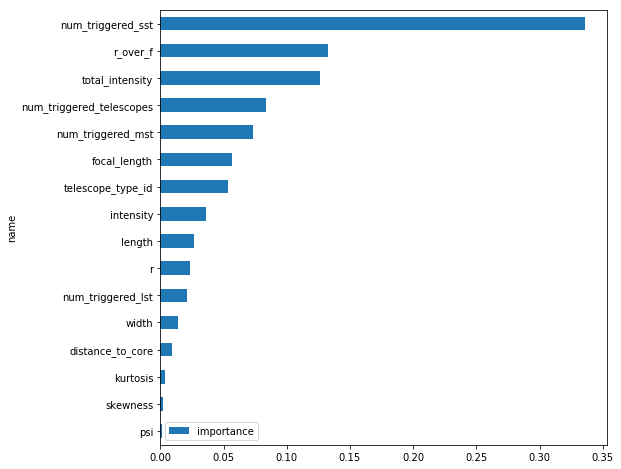

In [29]:
X_train, X_test, y_train, y_test = train_test_split(df[col_ar + col_tel], df.mc_energy, test_size=0.33, shuffle=False)

print(X_train.shape, y_train.shape)
rf = RandomForestRegressor(n_estimators=250, min_samples_leaf=4, n_jobs=20, max_features='sqrt')
rf.fit(X_train, np.log10(y_train))

e_reco = 10**rf.predict(X_test)
predictions = np.array([dt.predict(X_test, check_input=True) for dt in rf.estimators_])
e_reco_std = np.log10(predictions).std(axis=0)

df_importance = pd.DataFrame({'importance': rf.feature_importances_ , 'name':X_train.columns.values})
df_importance.index = df_importance.name
df_importance = df_importance.sort_values(by='importance', ascending=True)
df_importance.plot.barh(figsize=(8, 8))

0.7444348532128533
0.7514028375736499


(0, 0.45)

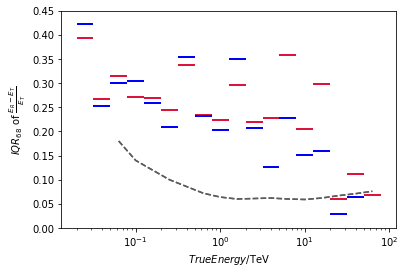

In [30]:
plot_energy_resolution(y_test, e_reco, bins=bin_edges, color='crimson')
df = X_test.copy()
df['gamma_energy_prediction'] = e_reco
df['gamma_energy_prediction_std'] = e_reco_std
df['mc_energy'] = y_test
r = df.groupby(['run_id', 'array_event_id']).agg({'gamma_energy_prediction': np.mean, 'mc_energy': 'first'})


plot_energy_resolution(r.mc_energy, r.gamma_energy_prediction, bins=bin_edges, color='blue')
plt.ylim([0, 0.45])



/usr/local/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/usr/local/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
/usr/local/lib/python3.6/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

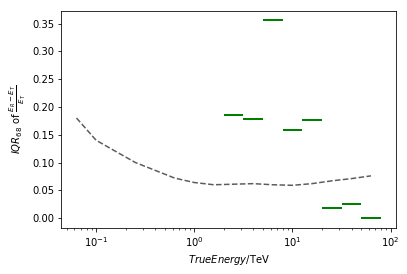

In [31]:
df = X_test.copy()
df['gamma_energy_prediction'] = e_reco * 1/e_reco_std**2
df['gamma_energy_prediction_std'] = e_reco_std
df['weight'] = 1/e_reco_std**2
df['mc_energy'] = y_test
r = df.groupby(['run_id', 'array_event_id']).agg({'gamma_energy_prediction': np.sum, 'mc_energy': 'first', 'weight':np.sum})
plot_energy_resolution(r.mc_energy, r.gamma_energy_prediction / r.weight, bins=bin_edges, color='green')
plt.ylim([0, 0.45])

0.8105637499793891


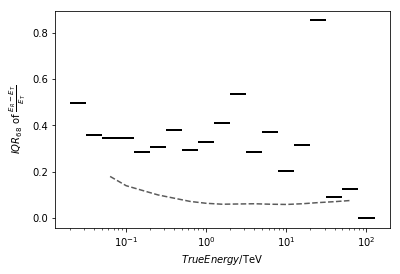

In [23]:
df = X_test.copy()
df['gamma_energy_prediction'] = e_reco
df['gamma_energy_prediction_std'] = e_reco_std
df['mc_energy'] = y_test

# df = df.query('gamma_energy_prediction_std < 0.1')
plot_energy_resolution(df.mc_energy, df.gamma_energy_prediction, bins=bin_edges, color='black')

In [209]:
w = 1/e_reco_std**2
# w = 1
X_test['e_reco_std'] = e_reco_std
X_test['weight'] = w
X_test['e_reco'] = e_reco
X_test['e_reco_weighted'] = e_reco*w
X_test['mc_energy'] = y_test
X_test_array_events = X_test.groupby(['run_id', 'array_event_id']).agg({'e_reco_weighted': np.sum, 'mc_energy':'first', 'weight':np.sum})
X_test_array_events['gamma_energy_prediction'] = X_test_array_events.e_reco_weighted / X_test_array_events.weight

0.8623696346848411
0.8086499437969555


(0, 0.45)

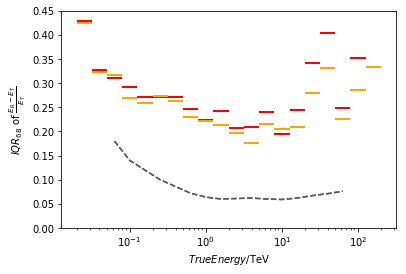

In [210]:
ax = plot_energy_resolution(y_test, e_reco, bins=bin_edges, color='red')
plot_energy_resolution(X_test_array_events['mc_energy'], X_test_array_events['gamma_energy_prediction'], bins=bin_edges, color='orange', ax=ax)
ax.set_ylim([0, 0.45])